In [1]:
import pickle
import pandas as pd
pd.set_option('display.max_columns',None)
import itertools
from functools import partial
from collections import defaultdict

import numpy as np
from dyntapy import get_toy_network
from dyntapy.visualization import show_network, show_demand
from dyntapy.supply_data import relabel_graph
from dyntapy.demand_data import od_graph_from_matrix, add_centroids
from dyntapy.results import get_od_flows
from dyntapy.assignments import StaticAssignment

import geopandas as gpd
from typing import Set, Tuple, List, Dict, Optional
import igraph
import random
import logging
from pathlib import Path
from pickle import load
import time
import networkx as nx
from zipfile import ZipFile
import os

# requires local installation of ireiat package using 
from ireiat.util.cacheable import CACHE_PATH

### First let's solve a toy problem

In [2]:
# load a silly network
g = get_toy_network('cascetta')
labeled_g = relabel_graph(g)
# show_network(labeled_g, euclidean=True)

C:\Users\nicholas.padon\AppData\Local\Programs\Python\Python311\Lib\site-packages\dyntapy\supply_data.py:824: UserWarning: The `euclidean_dist_vec` function has been renamed `euclidean`. Calling `euclidean_dist_vec` will raise an error in a future release.
  data["length"] = euclidean_dist_vec(y0, x0, y1, x1)


In [9]:
# we've picked some random centroids that are close to nodes 1 and 4 in the original graph
centroid_x = np.array([1, 7])
centroid_y = np.array([1, 1])

# add these centroids as "centroid" nodes (against which O-D flows will be specified)
# also automatically adds connectors (with capacities, etc.) from the centroids to the nearest nodes on the node-link graph
fg = add_centroids(g, centroid_x, centroid_y, euclidean=True, method="link") # on the unlabeled graph
fg = relabel_graph(fg)  # adding link and node ids, connectors and centroids
show_network(fg, euclidean=True)

C:\Users\nicholas.padon\AppData\Local\Programs\Python\Python311\Lib\site-packages\dyntapy\demand_data.py:829: UserWarning: The `euclidean_dist_vec` function has been renamed `euclidean`. Calling `euclidean_dist_vec` will raise an error in a future release.
  dists = euclidean_dist_vec(
C:\Users\nicholas.padon\AppData\Local\Programs\Python\Python311\Lib\site-packages\dyntapy\demand_data.py:829: UserWarning: The `euclidean_dist_vec` function has been renamed `euclidean`. Calling `euclidean_dist_vec` will raise an error in a future release.
  dists = euclidean_dist_vec(


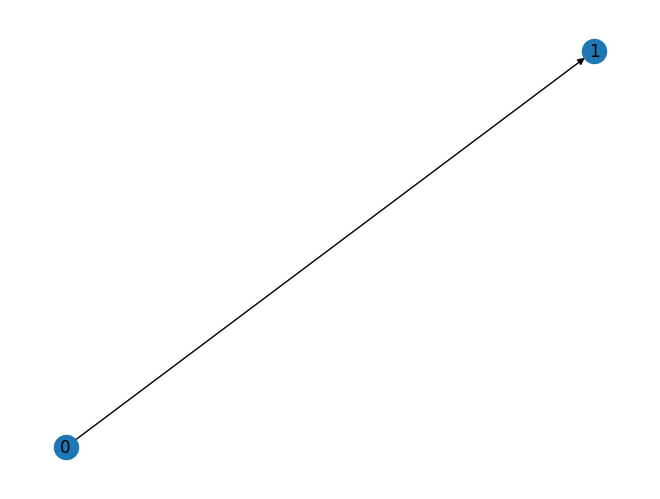

In [39]:
# and for the demand (we want 3000 demand going from centroid 0->1 (which corresponds to node 1->4 on the node-link graph)
od_matrix = np.zeros(len(centroid_x)*len(centroid_y)).reshape((len(centroid_x), len(centroid_y)))
od_matrix[0, 1] = 3000
od_graph = od_graph_from_matrix(od_matrix, centroid_x, centroid_y)
nx.draw(od_graph,with_labels=True)

In [44]:
od_graph.nodes.data()

NodeDataView({0: {'x_coord': 1, 'y_coord': 1}, 1: {'x_coord': 7, 'y_coord': 1}})

In [43]:
od_graph.edges.data()

OutEdgeDataView([(0, 1, {'flow': 3000.0})])

In [40]:
sa = StaticAssignment(fg, od_graph)

init passed successfully


In [41]:
result = sa.run(method='dial_b') # uses numba, so first run needs compilation time

solution found, Dial B in iteration 1


In [42]:
result

StaticResult(link_costs=array([5.00607524e-04, 5.00000024e-04, 3.02287902e-02, 2.51094650e-02,
       5.41196096e-06, 2.35702265e-02, 3.02287902e-02, 2.50000004e-02,
       3.53486252e-02, 2.35702265e-02, 2.50000004e-02, 1.66666675e-02,
       2.50000004e-02, 1.10670513e-05, 5.00000024e-04, 5.41853649e-06,
       5.00607524e-04, 1.10536212e-05]), flows=array([3000.        ,    0.        , 2173.31398144,  826.68601856,
          0.        ,    0.        , 2173.31398144,    0.        ,
        826.68601856,    0.        ,    0.        ,    0.        ,
          0.        , 3000.        ,    0.        , 3000.        ,
       3000.        ,    0.        ]), origins=array([0], dtype=uint32), destinations=array([1], dtype=uint32), origin_flows=None, destination_flows=array([[3000.        ,    0.        , 2173.31398144,  826.68601856,
           0.        ,    0.        , 2173.31398144,    0.        ,
         826.68601856,    0.        ,    0.        ,    0.        ,
           0.        , 3

In [29]:
[(f, some_edge) for f, some_edge in zip(result.flows, fg.edges(data=True)) if some_edge[2].get('connector',False)==False and f > 0]

[(2173.3139814415235,
  (2,
   3,
   {'length': 2.0,
    'capacity': 2000,
    'free_speed': 80,
    'lanes': 2,
    'link_id': 2,
    'from_node_id': 2,
    'to_node_id': 3})),
 (826.6860185584768,
  (2,
   4,
   {'length': 2.0,
    'capacity': 2000,
    'free_speed': 80,
    'lanes': 1,
    'link_id': 3,
    'from_node_id': 2,
    'to_node_id': 4})),
 (2173.3139814415235,
  (3,
   5,
   {'length': 2.0,
    'capacity': 2000,
    'free_speed': 80,
    'lanes': 2,
    'link_id': 6,
    'from_node_id': 3,
    'to_node_id': 5})),
 (826.6860185584768,
  (4,
   5,
   {'length': 2.0,
    'capacity': 500,
    'free_speed': 120,
    'lanes': 1,
    'link_id': 8,
    'from_node_id': 4,
    'to_node_id': 5}))]